In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from stldecompose import decompose
import plotly as py
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
# XGB regressor for Amazon (AMZ)
# high tech 

In [3]:
df1 = pd.read_csv("AMZ.csv")
df1['Date'] = pd.to_datetime(df1['Date'])
df1.head()

,Mnemonic,Date,MaxPrice,MinPrice,StartPrice,EndPrice
0,AMZ,2018-06-18,1487.34,1465.01,1477.08,1485.49
1,AMZ,2018-06-19,1485.87,1470.54,1474.11,1480.98
2,AMZ,2018-06-20,1514.00,1502.12,1509.97,1511.53
3,AMZ,2018-09-04,1774.39,1743.09,1756.03,1772.64
4,AMZ,2018-09-05,1763.85,1715.22,1762.23,1724.06


In [4]:
# since the distributed file system does not preserve order of the data
# we have to sort the data by Date
df = df1.sort_values(by = 'Date')
# check to see whether we have successfully sorted or not
df.head()

,Mnemonic,Date,MaxPrice,MinPrice,StartPrice,EndPrice
297,AMZ,2018-01-02,985.0,967.0,973.0,983.0
298,AMZ,2018-01-03,998.0,987.0,987.0,996.0
299,AMZ,2018-01-04,1006.0,1000.0,1002.0,1000.0
420,AMZ,2018-01-05,1014.0,1004.0,1006.0,1010.0
421,AMZ,2018-01-08,1044.0,1026.0,1030.0,1040.0


In [5]:
df_close = df[['Date', 'EndPrice']].copy()
df_close = df_close.set_index('Date')
df_close.head()

,EndPrice
Date,
2018-01-02,983.0
2018-01-03,996.0
2018-01-04,1000.0
2018-01-05,1010.0
2018-01-08,1040.0


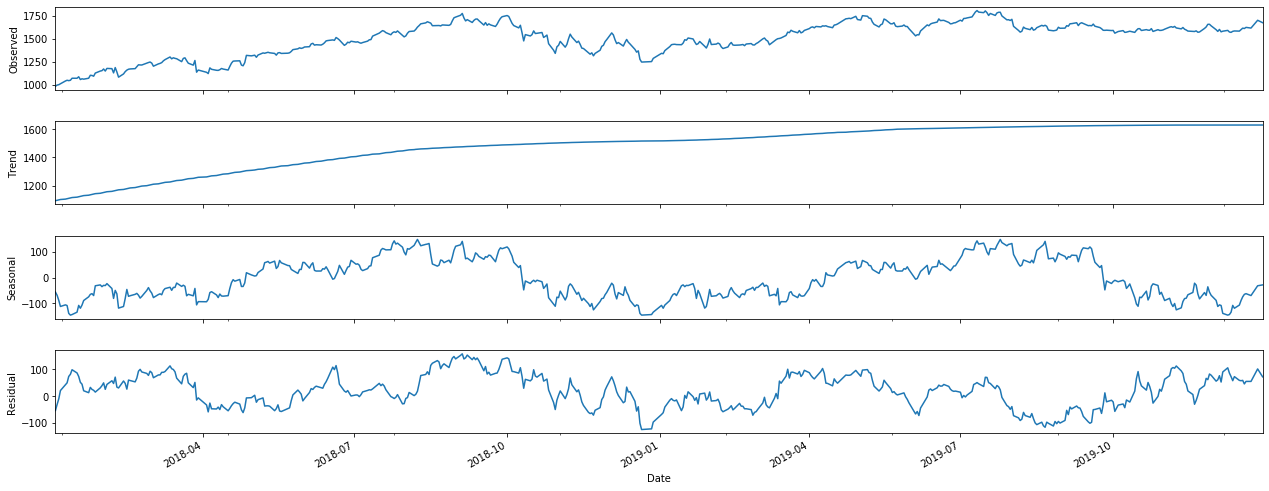

In [6]:
decomp = decompose(df_close, period = 240)
fig = decomp.plot()
fig.set_size_inches(20, 8)

In [7]:
#moving averages
# simple moving averages and exponential moving averages
# exponential moving averages
df['EMA_9'] = df['EndPrice'].ewm(9).mean().shift()
# simple moving averages
df['SMA_5'] = df['EndPrice'].rolling(5).mean().shift()
df['SMA_10'] = df['EndPrice'].rolling(10).mean().shift()
df['SMA_15'] = df['EndPrice'].rolling(15).mean().shift()
df['SMA_20'] = df['EndPrice'].rolling(20).mean().shift()


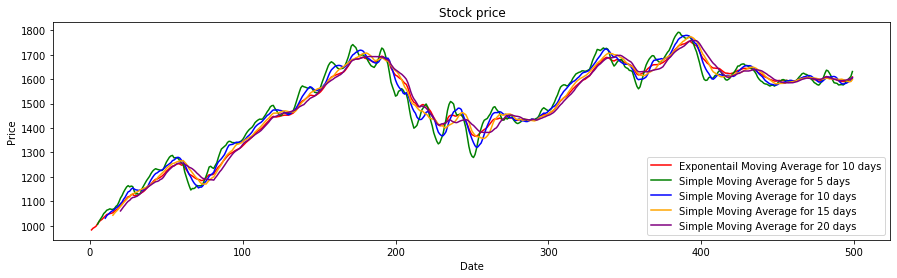

In [8]:
# plot moving averages to see whether they are good indicators of the close price
plt.figure(figsize=(15, 4));
plt.plot(df.EMA_9.values, color ='red', label ='Exponentail Moving Average for 10 days')
plt.plot(df.SMA_5.values, color ='green', label='Simple Moving Average for 5 days')
plt.plot(df.SMA_10.values, color ='blue', label = "Simple Moving Average for 10 days")
plt.plot(df.SMA_15.values, color ='orange', label ='Simple Moving Average for 15 days')
plt.plot(df.SMA_20.values, color ='purple', label ='Simple Moving Average for 20 days')

plt.title('Stock price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')

In [9]:
# function for relative strength index
def relative_strength_index(df, n=14):
    close = df['EndPrice']
    delta = close.diff()
    delta = delta[1:]
    priceUp = delta.copy()
    priceDown = delta.copy()
    priceUp[priceUp < 0] = 0
    priceDown[priceDown > 0] = 0
    rollUp = priceUp.rolling(n).mean()
    rollDown = priceDown.abs().rolling(n).mean()
    rollchange = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rollchange))
    return rsi

# apply the function to the dataframe
df['RSI'] = relative_strength_index(df).fillna(0)

In [10]:
# MACD
EMA_12 = pd.Series(df['EndPrice'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['EndPrice'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

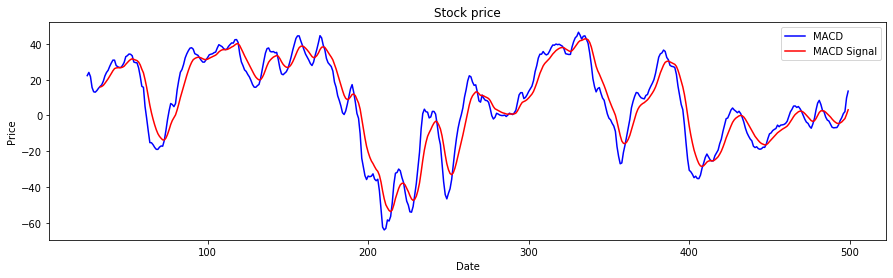

In [11]:
# plot MACD and MACD signals to see whether they are good indicators of the close price
plt.figure(figsize=(15, 4));
plt.plot(df.MACD.values, color ='blue', label = "MACD")
plt.plot(df.MACD_signal.values, color ='red', label ='MACD Signal')


plt.title('Stock price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')

In [12]:
# shift label col for time series analysis
df['EndPrice'] = df['EndPrice'].shift(-1)

In [13]:
# drop invalid samples
df = df.iloc[33:] # Because of moving averages and MACD line
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

In [15]:
test_size  = 0.10
valid_size = 0.10

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()


In [16]:
# drop cols that are not going to be included in the model
drop_cols = ['Date','StartPrice', 'MinPrice', 'MaxPrice', 'Mnemonic']

# drop cols for training, test, and validation sets
train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

In [17]:
# define predictors and responses
y_train = train_df['EndPrice'].copy()
X_train = train_df.drop(['EndPrice'], 1)
y_valid = valid_df['EndPrice'].copy()
X_valid = valid_df.drop(['EndPrice'], 1)
y_test  = test_df['EndPrice'].copy()
X_test  = test_df.drop(['EndPrice'], 1)



In [18]:
# define parameters
parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 15, 20],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [55]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

/Users/jingjie_ma/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



[17:17:06] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:07] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:07] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:07] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:07] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:07] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:08] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:08] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:08] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:09] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:09] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:09] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:10] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:10] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:10] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:11] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:11] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:11] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:12] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:12] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:12] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:12] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:12] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:13] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:14] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:14] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:14] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:16] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:16] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:16] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:18] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:18] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:18] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:19] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:19] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:19] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:20] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:20] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:20] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:21] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:21] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:21] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:22] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:22] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:22] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:23] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:24] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:24] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:25] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:25] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:25] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:26] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:26] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:27] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:28] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:28] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:28] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:30] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:30] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:30] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:31] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:31] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:31] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:32] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:32] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:32] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:33] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:33] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:33] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:34] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:34] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:34] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:35] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:35] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:35] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:36] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:36] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:36] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:38] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:38] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:38] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:41] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:41] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:41] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:42] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:42] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:42] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:43] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:43] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:43] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:44] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:44] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:44] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:45] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:45] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:45] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:46] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:46] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:46] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:47] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:47] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:47] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:48] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:48] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:48] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:50] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:50] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:50] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

[17:17:53] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:53] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.cc:485: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:53] WARNING: /Users/jingjie_ma/xgboost/my_build/xgboost/python-package/build/temp.macosx-10.7-x86_64-3.6/xgboost/src/learner.

/Users/jingjie_ma/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



In [19]:
# fit the model
model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.02, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=55, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

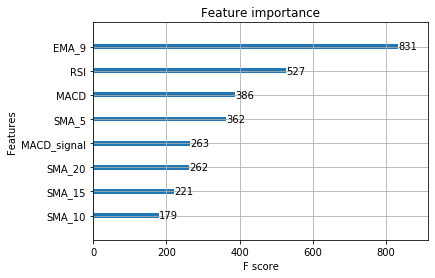

In [20]:
# plot importance plot of the model
plot_importance(model);

In [21]:
# predict on test sets
y_pred = model.predict(X_test)

In [22]:
y_preds = y_pred[:26]
y_true = np.array(y_test)[:26]


In [23]:
# print mse
print(f'MSE = {mean_squared_error(y_true, y_preds)}')

MSE = 1389.866055555021
